Here I will have some examples showing how to use Sampyl. This is for version 0.2.2. Let's import it and get started. Sampyl is a Python package used to sample from probability distributions using Markov Chain Monte Carlo (MCMC). This is most useful when sampling from the posterior distribution of a Bayesian model.

Every sampler provided by Sampyl works the same way. Define $ \log P(\theta) $ as a function, then pass it to the sampler class. The class returns a sampler object, which you can then use to sample from $P(\theta)$. For samplers which use the gradient, $\nabla_{\theta} \log P(\theta)$, Sampyl uses [autograd](https://github.com/HIPS/autograd) to automatically calculate the gradients. However, you can pass in your own $\nabla_{\theta} \log P(\theta)$ functions.

Starting out simple, let's sample from a normal distribution.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import sampyl as smp
from sampyl import np

# Autgrad throws some warnings that are useful, but this is
# a demonstration, so I'll squelch them.
import warnings
warnings.filterwarnings('ignore')

A normal distribution with mean $\mu$ and variance $\sigma^2$ is defined as:

$$
P(x,\mu, \sigma) = \frac{1}{\sigma \sqrt{2 \pi}} \; \mathrm{Exp}\left( \frac{-(x - \mu)^2}{2\sigma^2} \right)
$$

For numerical stability, it is typically better to deal with log probabilities, $\log{P(\theta)}$. Then for the normal distribution with known mean and variance,

$$
\log{P(x \mid \mu, \sigma)} = -\log{\sigma} - \frac{(x - \mu)^2}{2\sigma^2} 
$$

where we can drop constant terms since the MCMC samplers only require something proportional to $\log{P(\theta)}$. We can easily write this as a Python function.

In [2]:
mu, sig = 3, 2
def logp(x):
    return  -np.log(sig) - (x - mu)**2/(2*sig**2)

First we'll use a Metropolis-Hastings sampler. Each sampler requires a $\log{P(\theta)}$ function and a starting state. We have included a function to calculate the *maximum a posteriori* (MAP) to find the peak of the distribution for use as the starting state. Then you call the sample method and a chain of samples is returned.

In [3]:
start = smp.find_MAP(logp, {'x':1.})
metro = smp.Metropolis(logp, start)
chain = metro.sample(10000, burn=2000, thin=4)

Progress: [##############################] 10000 of 10000 samples


We can retrieve the chain by accessing the attributes defined by the parameter name(s) of `logp`.

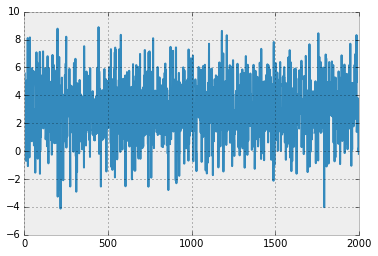

In [4]:
plt.plot(chain.x)

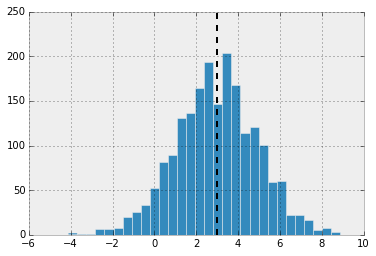

In [5]:
_ = plt.hist(chain.x, bins=30)
_ = plt.vlines(mu, 0, 250, linestyles='--')

Here we have sampled from a normal distribution with a mean of 3, indicated with the dashed vertical line.

There is also a No-U-Turn Sampler (NUTS), which avoids the random-walk nature of Metropolis samplers. NUTS uses the gradient of $\log{P(\theta)}$ to make intelligent state proposals. You'll notice here that we don't pass in any information about the gradient. Instead, it is calculated automatically with [autograd](https://github.com/HIPS/autograd).

In [7]:
1 in np.array([1,2,3])

True

In [6]:
nuts = smp.NUTS(logp, start)
chain = nuts.sample(100)

AttributeError: 'NotImplementedType' object has no attribute '__mul__'

In [19]:
nuts.model.grad(nuts.state)

State([('x', 4.9772580222224461)])

In [18]:
nuts.state

State([('x', 4.9772580222224461)])

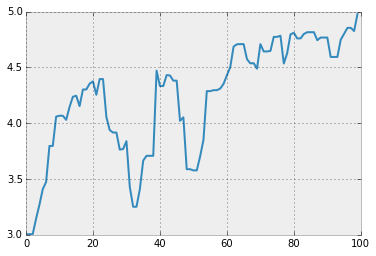

In [17]:
plt.plot(chain)

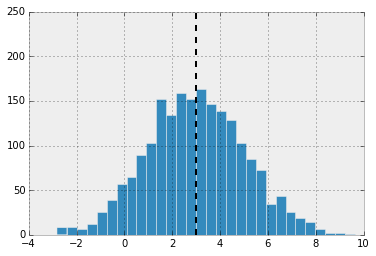

In [8]:
_ = plt.hist(chain.x, bins=30)
_ = plt.vlines(mu, 0, 250, linestyles='--')

## Bayesian estimation of phone call rates

Let's try something a little more complicated. Let's say you run a business and you put an advertisement in the paper. Then, to judge the effectiveness of the ad, you want to compare the number of incoming phone calls per hour before and after the placement of the add. Then we can build a Bayesian model using a Poisson likelihood with exponential priors for $\lambda_1$ and $\lambda_2$.


\begin{align}
P(\lambda_1, \lambda_2 \mid D) &\propto P( D \mid \lambda_1, \lambda_2)\, P(\lambda_1)\, P(\lambda_2) \\
P( D \mid \lambda_1, \lambda_2) &\sim \mathrm{Poisson}(D\mid\lambda_1)\,\mathrm{Poisson}(D\mid\lambda_2) \\
P(\lambda_1) &\sim \mathrm{Exp}(1) \\
P(\lambda_2) &\sim \mathrm{Exp}(1) 
\end{align}

This analysis method is known as Bayesian inference or Bayesian estimation. We want to know likely values for $\lambda_1$ and $\lambda_2$. This information is contained in the posterior distribution $P(\lambda_1, \lambda_2 \mid D)$. To infer values for $\lambda_1$ and $\lambda_2$, we can sample from the posterior using our MCMC samplers.

In [9]:
# Fake data for the day before and after placing the ad.
# We'll make the calls increase by 2 an hour. Record data for each
# hour over two work days.
before = np.random.poisson(7, size=16)
after = np.random.poisson(9, size=16)

# Define the log-P function here
def logp(lam1, lam2):
    # Rates for Poisson must be > 0
    if lam1 <= 0 or lam2 <=0:
        return -np.inf
    else:
        # logps for likelihoods
        llh1 = np.sum(before*np.log(lam1)) - before.size*lam1
        llh2 = np.sum(after*np.log(lam2)) - after.size*lam2
        
        # Exponential priors for lams
        lam1_prior = -lam1
        lam2_prior = -lam2
        return llh1 + llh2 + lam1_prior + lam2_prior

In [11]:
start = smp.find_MAP(logp, {'lam1':1., 'lam2':1.})
metro = smp.Metropolis(logp, start)
chain = metro.sample(10000, burn=2000, thin=4)

Progress: [##############################] 10000 of 10000 samples


Sampling returns a numpy record array which you can use to access samples by name. Variable names are taken directly from the argument list of `logp`.

In [12]:
print(metro.var_names)

('lam1', 'lam2')


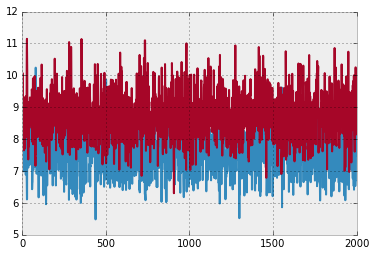

In [13]:
plt.plot(chain.lam1)
plt.plot(chain.lam2)

Now to see if there is a significant difference between the two days. We can find the difference $\delta =  \lambda_2 - \lambda_1$, then find the probability that $\delta > 0$.

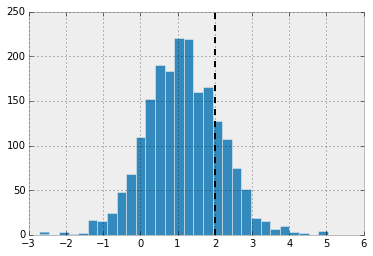

In [14]:
delta = chain.lam2 - chain.lam1
_ = plt.hist(delta, bins=30)
_ = plt.vlines(2, 0, 250, linestyle='--')

In [15]:
p = np.mean(delta > 0)
effect = np.mean(delta)
CR = np.percentile(delta, (2.5, 97.5))
print("{:.3f} probability the rate of phone calls increased".format(p))
print("delta = {:.3f}, 95% CR = {{{:.3f} {:.3f}}}".format(effect, *CR))

0.888 probability the rate of phone calls increased
delta = 1.146, 95% CR = {-0.775 3.116}


There true difference in rates is two per hour, marked with the dashed line. Our posterior is showing an effect, but our best estimate is that the rate increased by only one call per hour. The 95% credible region is {-0.865 2.982} which idicates that there is a 95% probability that the true effect lies with the region, as it indeed does.

We can alo use NUTS to sample from the posterior.

Progress: [##############################] 2100 of 2100 samples


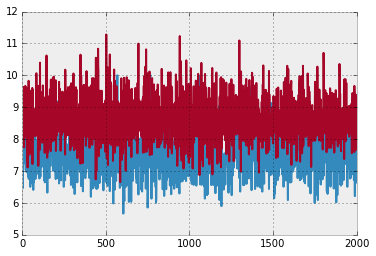

In [16]:
nuts = smp.NUTS(logp, start)
chain = nuts.sample(2100, burn=100)
_ = plt.plot(chain.lam1)
_ = plt.plot(chain.lam2)

0.874 probability the rate of phone calls increased
delta = 1.125, 95% CR = {-0.797 2.987}


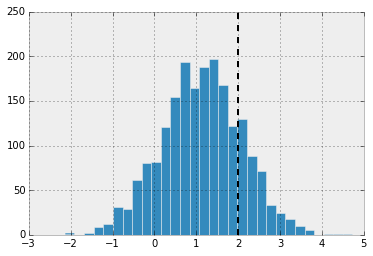

In [17]:
delta = chain.lam2 - chain.lam1
_ = plt.hist(delta, bins=30)
_ = plt.vlines(2, 0, 250, linestyle='--')
p = np.mean(delta > 0)
effect = np.mean(delta)
CR = np.percentile(delta, (2.5, 97.5))
print("{:.3f} probability the rate of phone calls increased".format(p))
print("delta = {:.3f}, 95% CR = {{{:.3f} {:.3f}}}".format(effect, *CR))

## Linear models too

When you build larger models, it would be cumbersome to have to include every parameter as an argument in the logp function. To avoid this, you can declare the size of variables when passing in the starting state.

For instance, with a linear model it would be great to pass the coefficients as one parameter. First, we'll make some fake data, then infer the coefficients.

In [10]:
# Number of data points
N = 200
# True parameters
sigma = 1
true_B = np.array([2, 1, 4])

# Simulated features, including a constant
X = np.ones((N, len(true_B)))
X[:,1:] = np.random.rand(N, len(true_B)-1)*2

# Simulated outcomes with normally distributed noise
y = np.dot(X, true_B) + np.random.randn(N)*sigma

data = np.ones((N, len(true_B) + 1))
data[:, :-1] = X
data[:, -1] = y

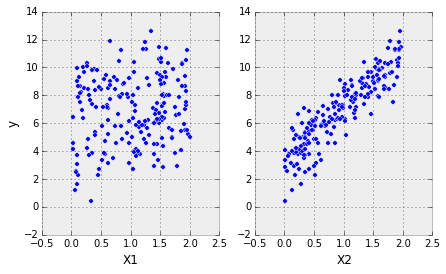

In [11]:
fig, axes = plt.subplots(figsize=(7,4),ncols=2)
for i, ax in enumerate(axes):
    ax.scatter(X[:,i+1], y)
axes[0].set_ylabel('y')
axes[0].set_xlabel('X1')
axes[1].set_xlabel('X2')

In [127]:
fig.savefig('linear_model_data.png')

In [12]:
# Here, b is a length 3 array of coefficients
def logp(b, sig):
    if sig <=0:
        return -np.inf
    y_hat = np.dot(X, b)
    likelihood = smp.normal(y, mu=y_hat, sig=sig)
    
    prior_sig = smp.exponential(sig)
    
    # Uniform priors on coefficients
    prior_b = smp.uniform(b, lower=-100, upper=100)
    
    return likelihood + prior_sig + prior_b

In [13]:
from autograd import grad

In [15]:
grads = [grad(logp, 0), grad(logp, 1)]

In [18]:
grads[1](np.ones(3), 1.)

3628.3927295261783

In [110]:
start = smp.find_MAP(logp, {'b': np.ones(3), 'sig': 1.}, 
                     bounds={'b':(-5, 10), 'sig':(0.01, None)})
metro = smp.Metropolis(logp, start)
chain = metro.sample(20000, burn=5000, thin=4)

Progress: [##############################] 20000 of 20000 samples


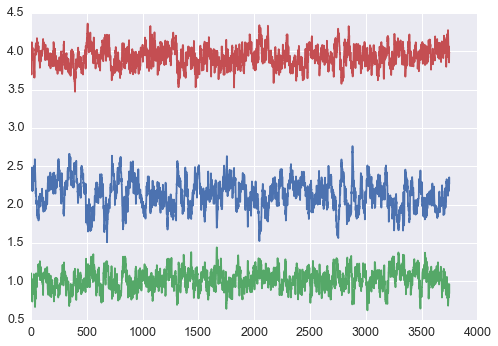

In [111]:
_ = plt.plot(chain.b)

And using NUTS too.

In [112]:
start = smp.find_MAP(logp, {'b': np.ones(3), 'sig': 1.})
nuts = smp.NUTS(logp, start)
chain = nuts.sample(2100, burn=100)

Progress: [##############################] 2100 of 2100 samples


In [68]:
import seaborn as sb

In [69]:
sb.set_context('notebook', font_scale=1.25)

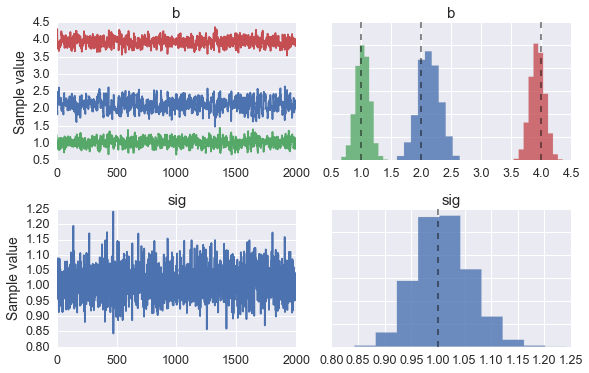

In [120]:
fig, axes = plt.subplots(figsize=(8,5), nrows=2, ncols=2)
for i, (row, param) in enumerate(zip(axes, [chain.b, chain.sig])):
    row[0].plot(param)
    row[0].set_ylabel('Sample value')
    #row[0].set_xlabel('Sample')
    row[0].set_title(['b', 'sig'][i])
    row[1].set_title(['b', 'sig'][i])
    if len(param.shape) > 1:
        for each in param.T:
            row[1].hist(each, alpha=0.8, histtype='stepfilled')
        row[1].set_yticklabels('')
        row[1].vlines([2,1,4], 0, 600, linestyles='--', alpha=0.5)
        
    else:
        row[1].hist(param, alpha=0.8, histtype='stepfilled')
        row[1].set_yticklabels('')
        row[1].vlines(1, 0, 600, linestyles='--', alpha=0.5)
    #row[1].set_xlabel('Sample value')
fig.tight_layout(pad=0.1, h_pad=1.5, w_pad=1)

In [121]:
fig.savefig('linear_model_posterior.png')

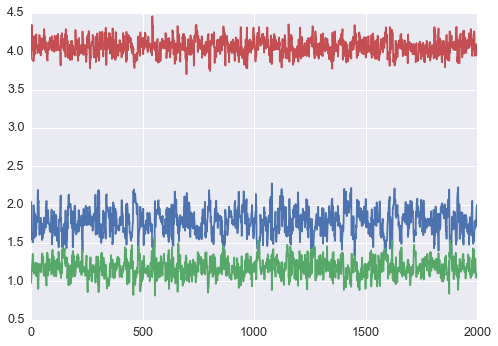

In [70]:

_ = plt.plot(chain.b)

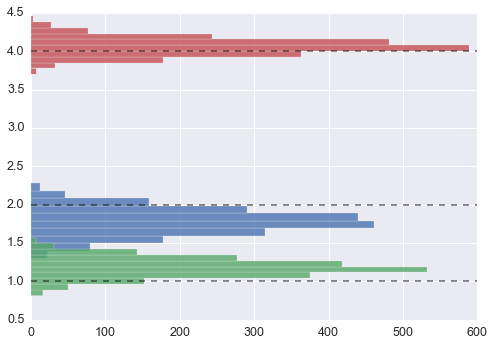

In [73]:
for each in chain.b.T:
    plt.hist(each, alpha=0.8, orientation='horizontal')
plt.hlines([2,1,4], 0, 600, linestyles='--', alpha=0.5)

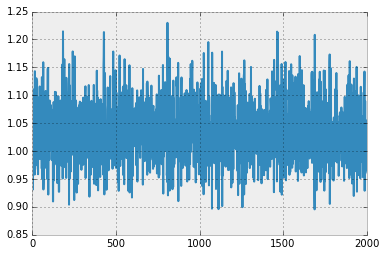

In [10]:
_ = plt.plot(chain.sig)

## Using one logp function for both logp and gradient

You can also use one `logp` function that returns both the logp value and the gradient. To let the samplers know about this, set `grad_logp = True`. I'm also using one argument `theta` as the parameter which contains the five $\beta$ coefficients and $\sigma$.

In [24]:
from autograd import grad
grads = [grad(logp, 0), grad(logp, 1)]
def single_logp(theta):
    b, sig = theta[:5], theta[-1]
    logp_val = logp(b, sig)
    grad_val = np.hstack([each(b, sig) for each in grads])
    return logp_val, grad_val

In [27]:
single_logp(start.tovector())

(-107.03408315518031,
 array([ -4.84281457e-05,  -1.09379841e-04,   6.21644571e-05,
          1.65228255e-04,  -1.43789309e-04,   1.78887423e-03]))

In [28]:
nuts = smp.NUTS(single_logp, {'theta':start.tovector()}, grad_logp=True)
chain = nuts.sample(1000)

Progress: [##############################] 1000 of 1000 samples


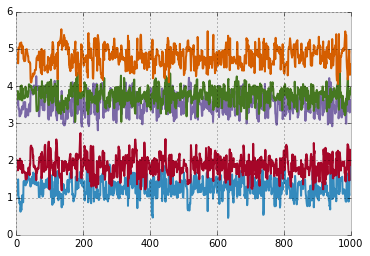

In [31]:
_ = plt.plot(chain.theta[:, :5])

## Sampling in parallel

We can make use of our multicore CPUs by running chains in parallel. To do this, simply request the number of chains you want when you call `sample`: `nuts.sample(1000, n_chains=4)`. Each chain is given its own process and the OS decides how to run the processes. Typically this means that each process will run on its own core. So, if you have four cores and four chains, they will all run in parallel. But, if you have two cores, only two will run at a time.

In [32]:
nuts = smp.NUTS(logp, start)
chains = nuts.sample(1000, n_chains=2)

Progress: [##############################] 1000 of 1000 samples


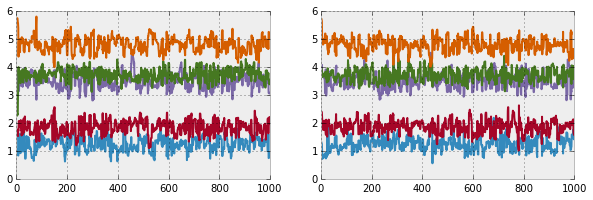

In [35]:
fig, axes = plt.subplots(figsize=(10,3), ncols=2)
for ax, chain in zip(axes, chains):
    _ = ax.plot(chain.b)

The future
----------

* Write a module that makes it easier to build logp functions from distributions
* Add various functions such as autocorrelation, HPD, etc.
* Plots!